# Quotes EDA Notebook

In [1]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
import time
import glob
import os
from PIL import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#### Helper functions for EDA 

In [2]:
def create_dataset_from_csv(directory_):
    path = r'./' + directory_
    allFiles = glob.glob(path + '/*.csv')
    list_ = []
    for file_ in allFiles:
        print(file_)
        df = pd.read_csv(file_,index_col=None, header=0)
        list_.append(df)
        df_all = pd.concat(list_)
    return df_all

In [3]:
def get_stopwords(word_lst):
    sw = stopwords.words('english')
    print("original stop_word count = ", len(sw))
    
    if len(word_lst) > 0:
        sw.extend(word_lst)
        
    sw_ = set(sw)
    print("new stop_word count = ", len(sw_))
    return sw_

In [4]:
def remove_punctuation(text):
    tokenizer= RegexpTokenizer(r'\w+|\$[\d\.]+')
    word_tokens = tokenizer.tokenize(text)
    return ' '.join(word_tokens)

In [5]:
def remove_stopwords(text, stopwords_, remove_punct=True):
    if remove_punct:
        text = remove_punctuation(text)
       
    word_tokens = word_tokenize(text)
        
    filtered_sentence = []
    for w in word_tokens:
        if w.lower() not in stopwords_:
            filtered_sentence.append(w)
    return ' '.join(filtered_sentence)

In [6]:
def lemmatize_text(text):
    words = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    # for verbs adjectives and nouns
    vlst = [lemmatizer.lemmatize(w, 'v') for w in words]
    alst = [lemmatizer.lemmatize(w, 'a') for w in vlst]
    nlst = [lemmatizer.lemmatize(w, 'n') for w in alst]
    return ' '.join(nlst)

In [7]:
def stem_text(text):
    words = word_tokenize(text)
    stemmer = SnowballStemmer("english")
    stemmed = [stemmer.stem(i) for i in words]
    return ' '.join(stemmed)

In [8]:
def show_wordclouds(dict_):
    ncol = 1
    nrow = 1
    index_ = 0
    figsize_ =(12,8)
    
    length_ = len(dict_)
    if length_ > 1 :
        if len(dict_) % 2 == 1:
            length_ += 1
        ncol = 2
        nrow = int(length_/2)
        figsize_ =(14,10)

    auth_info = []
    for key, value in dict_.items():
        auth_info.append([key, value])
        
    fig, ax_arr = plt.subplots(nrow, ncol, figsize=figsize_);
    
    if length_ == 1:
        config_axis(ax_arr, auth_info[index_ ][0], auth_info[index_ ][1])
    else:
        for ax in ax_arr:
            config_axis(ax[0], auth_info[index_][0], auth_info[index_][1])
            index_ += 1 
            if index_ == len(dict_):
                config_axis(ax[1], "empty","empty")
                break
            config_axis(ax[1], auth_info[index_][0], auth_info[index_][1])
            index_ += 1
        
    plt.show();
    
def config_axis(ax, author, text):
    wordcloud = WordCloud().generate(text)
    ax.set_title(author)
    ax.imshow(wordcloud, aspect='equal', interpolation='bilinear')
    ax.axis("off")

#### Create directory for datasets that will be generated with this notebook and used for modeling

In [9]:
# create dataset directory if needed
directory = "../datasets/"
if not os.path.exists(directory):
    os.makedirs(directory)
    print(directory, ' created!')

#### Read in scraped quote data

In [11]:
df_quotes = create_dataset_from_csv('../quote_data')
df_quotes.shape

./../quote_data/a_quotes.csv
./../quote_data/b_quotes.csv
./../quote_data/c_quotes.csv
./../quote_data/d_quotes.csv
./../quote_data/e_quotes.csv
./../quote_data/f_quotes.csv
./../quote_data/g_quotes.csv
./../quote_data/h_quotes.csv
./../quote_data/iq_quotes.csv
./../quote_data/j_quotes.csv
./../quote_data/k_quotes.csv
./../quote_data/l_quotes.csv
./../quote_data/m_quotes.csv
./../quote_data/n_quotes.csv
./../quote_data/o_quotes.csv
./../quote_data/p_quotes.csv
./../quote_data/r_quotes.csv
./../quote_data/s_quotes.csv
./../quote_data/t_quotes.csv
./../quote_data/uv_quotes.csv
./../quote_data/w_quotes.csv
./../quote_data/xyz_quotes.csv


(102455, 2)

In [12]:
# number of unique authors 
len(df_quotes.author.unique())

6945

In [103]:
df_quotes.shape

(102455, 2)

## Create dataset for Authors with highest quote count

#### Looking at the top 15 authors, I notice that some on the 'author' list are not individual authors.  Going to remove those and focus on people rather than books/scripture for this dataset.

In [13]:
df = pd.DataFrame(df_quotes.groupby(df_quotes.author).agg({'quote': 'size'})).reset_index()
df.sort_values('quote', ascending=False).head(15)

,author,quote
6200,Source Unknown,1386
530,Bible Bible,1139
5374,Ralph Waldo Emerson,888
4413,Mark Twain,679
6872,William Shakespeare,574
2197,Granth Sahib,574
5003,Oscar Wilde,509
6943,quran quran,486
161,Albert Einstein,485
2021,George Bernard Shaw,402


In [14]:
# Filter out Unknown and quotes from proverbs and religious scriptures for now
df_q2 = pd.DataFrame(df_quotes[~df_quotes["author"].str.strip().isin(['Source Unknown', 'Unknown', 'Granth Sahib',
                                                  'Bible Bible', 'quran quran', 'Chinese Proverbs'])])
len(df_q2.author.unique())

6939

In [15]:
# Will work with top 10
df_auth_grp = pd.DataFrame(df_q2.groupby(df_q2.author).agg({'quote': 'size'})).reset_index()
df_top10 = df_auth_grp.sort_values('quote', ascending=False).head(10)

authors = list(df_top10.author.values)
df_auths = df_q2[df_q2["author"].isin(authors)].reset_index(drop=True)
df_auths.shape

(5078, 2)

In [16]:
df_top10

,author,quote
5371,Ralph Waldo Emerson,888
4410,Mark Twain,679
6867,William Shakespeare,574
5000,Oscar Wilde,509
161,Albert Einstein,485
2019,George Bernard Shaw,402
249,Ambrose Gwinett Bierce,398
2352,Henry David Thoreau,396
1937,Friedrich Wilhelm Nietzsche,393
6026,Scott McClellan,354


In [17]:
stop_words = get_stopwords(["n't"])

original stop_word count =  179
new stop_word count =  180


In [18]:
df_auths['no_stopwords'] = df_auths['quote'].apply(lambda x: remove_stopwords(x, stop_words))
df_auths.columns

Index(['author', 'quote', 'no_stopwords'], dtype='object')

In [19]:
df_auths['lemmatized'] = df_auths['no_stopwords'].apply(lemmatize_text)
df_auths.columns

Index(['author', 'quote', 'no_stopwords', 'lemmatized'], dtype='object')

In [20]:
df_auths['stemmed'] = df_auths['lemmatized'].apply(stem_text)
df_auths.head(2)

,author,quote,no_stopwords,lemmatized,stemmed
0,Ambrose Gwinett Bierce,"RECRUIT, n. A person distinguishable from a ci...",RECRUIT n person distinguishable civilian unif...,RECRUIT n person distinguishable civilian unif...,recruit n person distinguish civilian uniform ...
1,Ambrose Gwinett Bierce,"RANK, n. Relative elevation in the scale of hu...",RANK n Relative elevation scale human worth,RANK n Relative elevation scale human worth,rank n relat elev scale human worth


In [21]:
# write dataset to file - for modeling
df_auths.to_csv(directory + "authors.csv", encoding='utf-8', index=False)

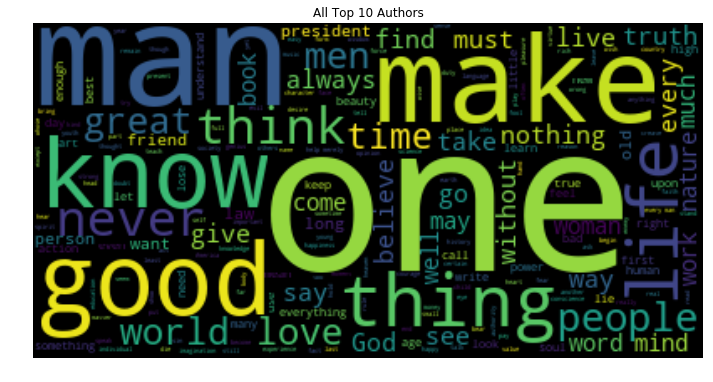

In [22]:
all_text = df_auths["lemmatized"].str.cat(sep=' ')
all_text
show_wordclouds({'All Top 10 Authors': all_text});

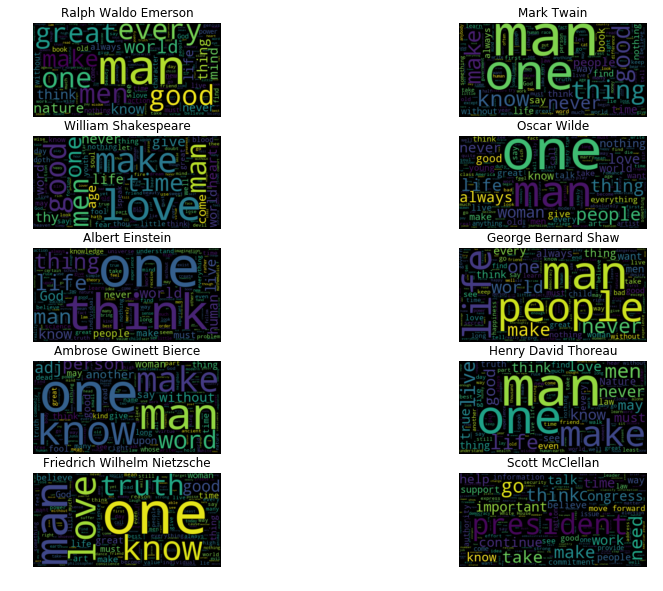

In [44]:
auth_dict = {}
for auth in authors:
    text = df_auths['lemmatized'][df_auths["author"] == auth].str.cat(sep=' ')
    auth_dict.update({auth:text})

show_wordclouds(auth_dict);

## Create dataset for scriptures quotes

In [57]:
books = ['Granth Sahib','Bible Bible', 'quran quran'] #'Chinese Proverbs'
df_script = pd.DataFrame(df_quotes[df_quotes["author"].isin(books)]).reset_index(drop=True)
len(df_script.author.unique())
df_script.head()

,author,quote
0,Bible Bible,"And Adam was not deceived, but the woman being..."
1,Bible Bible,All these trust to their hands: and every one ...
2,Bible Bible,"But unto thee have I cried, o Lord; and in the..."
3,Bible Bible,"With the work of an engraver in stone, like th..."
4,Bible Bible,And he made the robe of the ephod of woven wor...


In [101]:
df_script.shape

(2199, 5)

In [99]:
df_script.groupby("author").quote.size()

author
Bible Bible     1139
Granth Sahib     574
quran quran      486
Name: quote, dtype: int64

In [65]:
stpwords_ = get_stopwords(["unto", "thee", "ye", "thy"])

original stop_word count =  179
new stop_word count =  183


In [59]:
df_script['no_stopwords'] = df_script['quote'].apply(lambda x: remove_stopwords(x, stpwords_))
df_script.columns

Index(['author', 'quote', 'no_stopwords'], dtype='object')

In [60]:
df_script['lemmatized'] = df_script['no_stopwords'].apply(lemmatize_text)
df_script.columns

Index(['author', 'quote', 'no_stopwords', 'lemmatized'], dtype='object')

In [61]:
df_script['stemmed'] = df_script['lemmatized'].apply(stem_text)
df_script.head(2)

,author,quote,no_stopwords,lemmatized,stemmed
0,Bible Bible,"And Adam was not deceived, but the woman being...",Adam deceived woman deceived transgression,Adam deceive woman deceive transgression,adam deceiv woman deceiv transgress
1,Bible Bible,All these trust to their hands: and every one ...,trust hands every one wise work,trust hand every one wise work,trust hand everi one wise work


In [62]:
# write dataset to file - for modeling
df_script.to_csv(directory + "scripture.csv", encoding='utf-8', index=False)

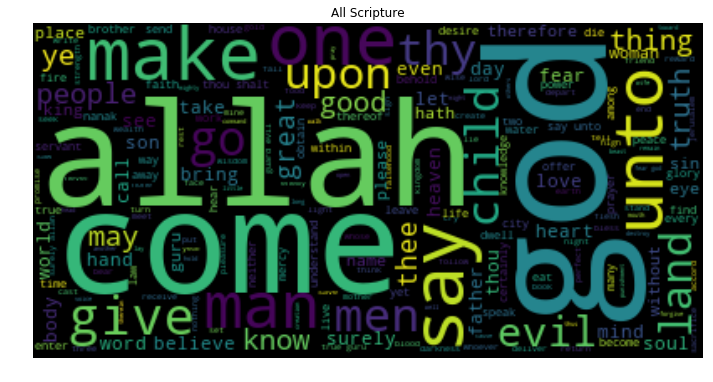

In [63]:
all_text = df_script['lemmatized'].apply(lambda x: x.lower()).str.cat(sep=' ')

show_wordclouds({'All Scripture':all_text});

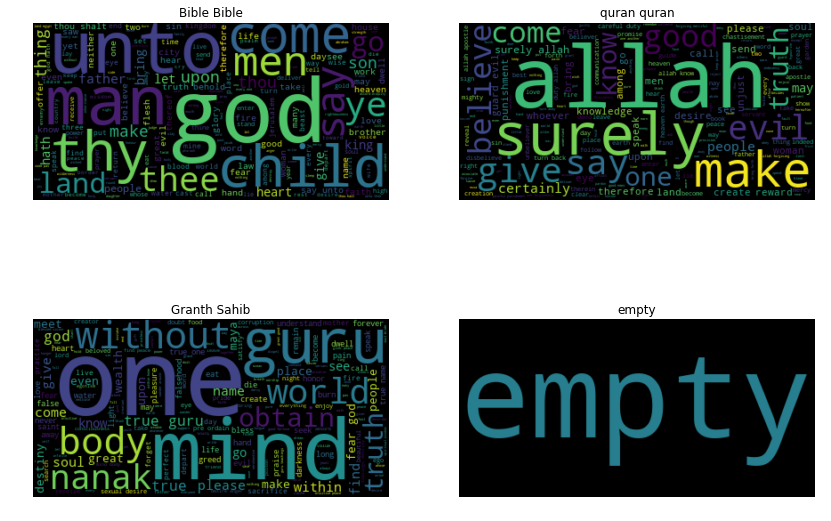

In [64]:
books = df_script.author.unique()
script_dict = {}
for b in books:
    text = df_script['lemmatized'].apply(lambda x: x.lower())[df_script["author"] == b].str.cat(sep=' ')
    script_dict.update({b:text})

show_wordclouds(script_dict);

### Prepare data for Topic Modeling

In [66]:
quotes_df = df_quotes.copy()

In [67]:
stop_words_ = get_stopwords(["n't", "unto", "thee", "ye", "thy"])

original stop_word count =  179
new stop_word count =  184


In [68]:
quotes_df['no_stopwords'] = quotes_df['quote'].apply(lambda x: remove_stopwords(x, stop_words_))
quotes_df.columns

Index(['author', 'quote', 'no_stopwords'], dtype='object')

In [69]:
quotes_df['lemmatized'] = quotes_df['no_stopwords'].apply(lemmatize_text)
quotes_df.columns

Index(['author', 'quote', 'no_stopwords', 'lemmatized'], dtype='object')

In [70]:
quotes_df['stemmed'] = quotes_df['lemmatized'].apply(stem_text)
quotes_df.head(2)

,author,quote,no_stopwords,lemmatized,stemmed
0,Alvar Aalto,Modern architecture does not mean the use of i...,Modern architecture mean use immature new mate...,Modern architecture mean use immature new mate...,modern architectur mean use immatur new materi...
1,Alvar Aalto,Building art is a synthesis of life in materia...,Building art synthesis life materialised form ...,Building art synthesis life materialise form t...,build art synthesi life materialis form tri br...


In [71]:
# write dataset to file - for modeling
print(quotes_df.shape)
quotes_df.to_csv(directory + "quotes.csv", encoding='utf-8', index=False)

(102455, 5)


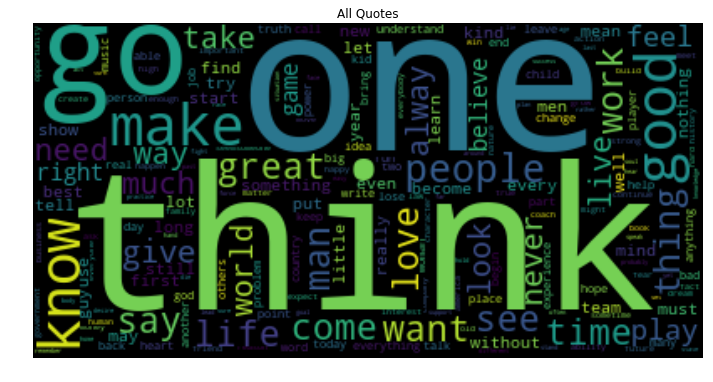

In [72]:
all_quotes = quotes_df['lemmatized'].apply(lambda x: x.lower()).str.cat(sep=' ')

show_wordclouds({'All Quotes':all_quotes});

## Prepare target datasets for further model testing

In [83]:
bible_target = pd.read_csv("datasets/Bible.csv", names=["quote", "author"])
bible_target

,quote,author
0,"She is clothed in strength, and dignity, and s...",Bible Bible
1,"The pain that you've been feeling, can't compa...",Bible Bible
2,Be bold. Be brave. Be courageous.,Bible Bible
3,There is a time for everything and a reason fo...,Bible Bible
4,"Don't be afraid, for I am with you. Don't be d...",Bible Bible
5,"He will cover you with His feathers, and under...",Bible Bible
6,"My soul finds rest in God alone, my salvation ...",Bible Bible
7,I can do everything through Christ who gives m...,Bible Bible
8,I will not cause pain without allowing somethi...,Bible Bible
9,"When you go through deep waters, I will be wit...",Bible Bible


In [84]:
bible_target['no_stopwords'] = bible_target['quote'].apply(lambda x: remove_stopwords(x, stop_words_))
bible_target.columns

Index(['quote', 'author', 'no_stopwords'], dtype='object')

In [85]:
bible_target['lemmatized'] = bible_target['no_stopwords'].apply(lemmatize_text)
bible_target.columns

Index(['quote', 'author', 'no_stopwords', 'lemmatized'], dtype='object')

In [86]:
bible_target['stemmed'] = bible_target['lemmatized'].apply(stem_text)
bible_target.head(2)

,quote,author,no_stopwords,lemmatized,stemmed
0,"She is clothed in strength, and dignity, and s...",Bible Bible,clothed strength dignity laughs without fear f...,clothe strength dignity laugh without fear future,cloth strength digniti laugh without fear futur
1,"The pain that you've been feeling, can't compa...",Bible Bible,pain feeling compare joy coming,pain feel compare joy come,pain feel compar joy come


In [87]:
# write dataset to file - for modeling
#bible_target.to_csv(directory + "bible_target.csv", encoding='utf-8', index=False)

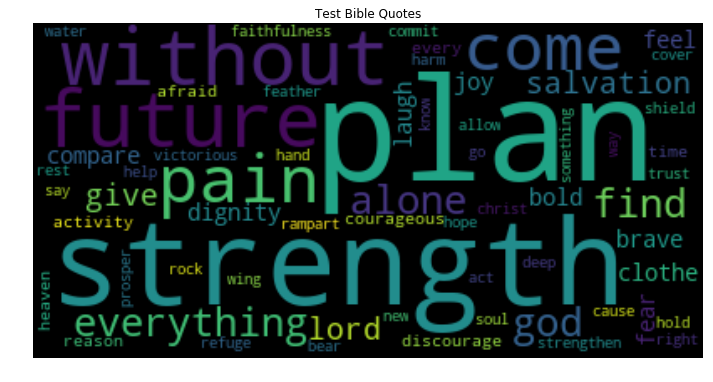

In [88]:
bible_target_quotes = bible_target['lemmatized'].apply(lambda x: x.lower()).str.cat(sep=' ')

show_wordclouds({'Test Bible Quotes':bible_target_quotes});

In [89]:
twain_target = pd.read_csv("datasets/mark_twain.csv", names=["quote", "author"])
twain_target

,quote,author
0,Age is an issue of mind over matter. If you do...,Mark Twain
1,"My mother had a great deal of trouble with me,...",Mark Twain
2,"Courage is resistance to fear, mastery of fear...",Mark Twain
3,All you need in this life is ignorance and con...,Mark Twain
4,Patriotism is supporting your country all the ...,Mark Twain
5,The first of April is the day we remember what...,Mark Twain
6,Never put off till tomorrow what you can do th...,Mark Twain
7,"In the Spring, I have counted 136 different ki...",Mark Twain
8,Kindness is the language which the deaf can he...,Mark Twain
9,The secret of getting ahead is getting started.,Mark Twain


In [90]:
twain_target['no_stopwords'] = twain_target['quote'].apply(lambda x: remove_stopwords(x, stop_words_))
twain_target.columns

Index(['quote', 'author', 'no_stopwords'], dtype='object')

In [91]:
twain_target['lemmatized'] = twain_target['no_stopwords'].apply(lemmatize_text)
twain_target.columns

Index(['quote', 'author', 'no_stopwords', 'lemmatized'], dtype='object')

In [92]:
twain_target['stemmed'] = twain_target['lemmatized'].apply(stem_text)
twain_target.head(2)

,quote,author,no_stopwords,lemmatized,stemmed
0,Age is an issue of mind over matter. If you do...,Mark Twain,Age issue mind matter mind matter,Age issue mind matter mind matter,age issu mind matter mind matter
1,"My mother had a great deal of trouble with me,...",Mark Twain,mother great deal trouble think enjoyed,mother great deal trouble think enjoy,mother great deal troubl think enjoy


In [93]:
# write dataset to file - for modeling
twain_target.to_csv(directory + "twain_target.csv", encoding='utf-8', index=False)

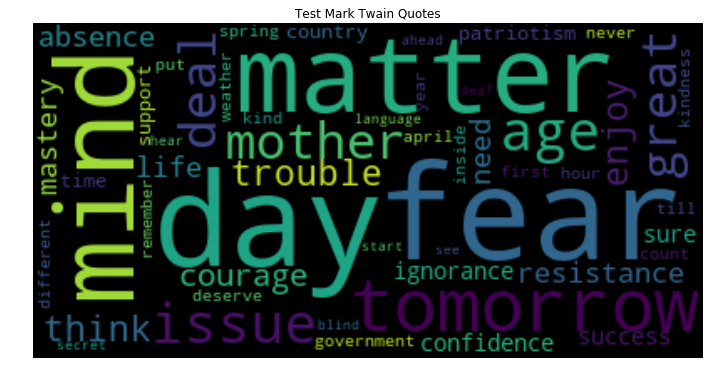

In [94]:
twain_target_quotes = twain_target['lemmatized'].apply(lambda x: x.lower()).str.cat(sep=' ')

show_wordclouds({'Test Mark Twain Quotes':twain_target_quotes});